# DTFE

In [1]:
#Load the numpy and scipy libraries
import numpy as np
from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union

@numba.jit(nopython=True, nogil=True)
def tetrahedron_volume(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]],
                                       points[sim[3]] - points[sim[0]])))) / 6

@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = tetrahedron_volume(sim, pts)
        for index in sim:
            rho[index] += vol
    return (3 + 1) * m / rho

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts: float64[:,:], simps: float64[:,:], rho: float64[:],
                      v: float64[:,:]) -> tuple[np.ndarray, np.ndarray]:
    N = len(simps)
    Drho = np.zeros((N, 3), dtype='float64')
    Dv   = np.zeros((N, 3, 3), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2, p3] = pts[s]
        [r0, r1, r2, r3] = rho[s]
        [v0, v1, v2, v3] = v[s]

        Ainv: float64[:,:] = np.linalg.inv(np.stack((p1 - p0, p2 - p0, p3 - p0)))
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0, r3 - r0])
        Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0, v3 - v0))
    return (Drho, Dv)

@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result

#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, velocities, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho, self.Dv = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho, self.velocities)

    #The interpolations
    def density(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])

    def v(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.velocities[pointIndex], self.Dv[simplexIndex],
                          np.c_[x, y, z] - self.delaunay.points[pointIndex])
    
    def gradV(self, x, y, z):
        return self.Dv[self.delaunay.find_simplex(np.c_[x, y, z])]

    def theta(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        return (self.Dv[simplexIndex][...,0,0] + 
                self.Dv[simplexIndex][...,1,1] + 
                self.Dv[simplexIndex][...,2,2])

    def sigma(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        Dv = self.Dv[simplexIndex]
        theta = Dv[...,0,0] + Dv[...,1,1] + Dv[...,2,2]
        return np.array([[Dv[...,0,0] - theta / 3       , (Dv[...,0,1] + Dv[...,1,0]) / 2, (Dv[...,0,2] + Dv[...,2,0]) / 2],
                        [(Dv[...,1,0] + Dv[...,0,1]) / 2,  Dv[...,1,1] - theta / 3       , (Dv[...,1,2] + Dv[...,2,1]) / 2],
                        [(Dv[...,2,0] + Dv[...,0,2]) / 2, (Dv[...,2,1] + Dv[...,1,2]) / 2,  Dv[...,2,2] - theta / 3       ]]) 
    
    def omega(self, x, y, z):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y, z])
        Dv = self.Dv[simplexIndex]
        zeros = np.zeros(len(simplexIndex))
        return (np.array([[zeros, (Dv[...,0,1] - Dv[...,1,0]) / 2, (Dv[...,0,2] - Dv[...,2,0]) / 2],
                          [(Dv[...,1,0] - Dv[...,0,1]) / 2, zeros, (Dv[...,1,2] - Dv[...,2,1]) / 2],
                          [(Dv[...,2,0] - Dv[...,0,2]) / 2, (Dv[...,2,1] - Dv[...,1,2]) / 2, zeros]])) 

# Nexus

In [2]:
def extend(points, velocities, L, pro):
    data = np.transpose(np.append(np.transpose(points),np.transpose(velocities), axis=0))
    temp = [[]];
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            for k in [-1,0,1]:
                temp = np.append(temp, data + [i * L, j * L, k * L, 0, 0, 0])

    temp = temp.reshape((int(len(temp) / 6), 6))
    temp = temp[(-pro * L < temp[:,0]) & (temp[:,0] < (1 + pro) * L) & 
                (-pro * L < temp[:,1]) & (temp[:,1] < (1 + pro) * L) &
                (-pro * L < temp[:,2]) & (temp[:,2] < (1 + pro) * L)]

    return [temp[:,(0,1,2)],temp[:,(3,4,5)]]

def GaussianSmooth(data, sigma):
    kRange = 2 * np.pi * np.fft.fftfreq(data.shape[0])
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    smooth_kernel = np.exp(- sigma ** 2 * (kx**2 + ky**2 + kz**2) / 2)

    return np.fft.ifftn(smooth_kernel * np.fft.fftn(data)).real 

def LogGaussianSmooth(data, sigma):
    f = 10**GaussianSmooth(np.log10(data), sigma)
    return np.mean(dens) / np.mean(f) * f

def gradient(data):
    kRange = 2 * np.pi * np.fft.fftfreq(data.shape[0])
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    
    datax = -np.fft.ifftn(kx * np.fft.fftn(data)).imag
    datay = -np.fft.ifftn(ky * np.fft.fftn(data)).imag
    dataz = -np.fft.ifftn(kz * np.fft.fftn(data)).imag
    
    return np.transpose(np.array([datax, datay, dataz]),(1,2,3,0))

def inverseLaplace(data):
    kRange = 2 * np.pi * np.fft.fftfreq(data.shape[0])
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    k2 = kx**2 + ky**2 + kz**2
    k2[0,0,0] = 1
    k2inv = 1 / k2
    k2inv[0,0,0] = 0
    
    return np.fft.ifftn(k2inv * np.fft.fftn(data)).real

def hessian(data):
    kRange = 2 * np.pi * np.fft.fftfreq(data.shape[0])
    kx, ky, kz = np.meshgrid(kRange, kRange, kRange)
    
    H11 = np.fft.ifftn(-kx * kx * np.fft.fftn(data)).real
    H12 = np.fft.ifftn(-kx * ky * np.fft.fftn(data)).real
    H13 = np.fft.ifftn(-kx * kz * np.fft.fftn(data)).real
    H22 = np.fft.ifftn(-ky * ky * np.fft.fftn(data)).real
    H23 = np.fft.ifftn(-ky * kz * np.fft.fftn(data)).real
    H33 = np.fft.ifftn(-kz * kz * np.fft.fftn(data)).real
    
    return np.transpose(np.array([[H11, H12, H13], 
                                  [H12, H22, H23], 
                                  [H13, H23, H33]]), (2, 3, 4, 0, 1))

@numba.jit(nopython=True, nogil=True)
def eigenvalues(hess: float64[:,:,:,:,:]):
    result = np.zeros((len(hess), 3))
    for i in range(len(hess)):
        result[i] = np.sort(np.linalg.eigvals(hess[i]).real)
    return result

@numba.jit(nopython=True, nogil=True)
def clusterSignature(ls: float64[:,:]):
    result = np.zeros(len(ls))
    for i in range(len(ls)):
        if ls[i, 2] < 0:
            result[i] = (abs(ls[i, 2]) * 
                         abs(ls[i, 2] / ls[i, 0]))
        else:
            result[i] = 0
    return result

@numba.jit(nopython=True, nogil=True)
def filamentSignature(ls: float64[:,:]):
    result = np.zeros(len(ls))
    for i in range(len(ls)):
        if ls[i, 1] < 0 and 1 - abs(ls[i, 2] / ls[i, 0]) > 0:
            result[i] = (abs(ls[i, 1]) * 
                         abs(ls[i, 1] / ls[i, 0]) * 
                         (1 - abs(ls[i, 2] / ls[i, 0])))
        else:
            result [i] = 0
    return result
    
@numba.jit(nopython=True, nogil=True)
def wallSignature(ls: float64[:,:]):
    result = np.zeros(len(ls))
    for i in range(len(ls)):
        if ls[i, 0] < 0 and 1 - abs(ls[i, 1] / ls[i, 0]) > 0  and 1 - abs(ls[i, 2] / ls[i, 0]) > 0:
            result[i] = (abs(ls[i, 0]) * 
                         (1 - abs(ls[i, 1] / ls[i, 0])) * 
                         (1 - abs(ls[i, 2] / ls[i, 0])))
        else:
            result[i] = 0
    return result
    
def Nexus_den(dens, sigma):
    N = dens.shape[0]
    hes   = sigma**2 * hessian(GaussianSmooth(dens, sigma))
    eigen = eigenvalues(hes.reshape((-1,3,3))).reshape((N, N, N, 3))

    cluster  = clusterSignature( eigen.reshape((-1,3))).reshape(N,N,N)
    filament = filamentSignature(eigen.reshape((-1,3))).reshape(N,N,N)
    wall     = wallSignature(    eigen.reshape((-1,3))).reshape(N,N,N)
    
    return (cluster, filament, wall)

def NexusPlus(dens, sigma):
    N = dens.shape[0]
    hes   = sigma**2 * hessian(LogGaussianSmooth(dens, sigma))
    eigen = eigenvalues(hes.reshape((-1,3,3))).reshape((N, N, N, 3))

    cluster  = clusterSignature( eigen.reshape((-1,3))).reshape(N,N,N)
    filament = filamentSignature(eigen.reshape((-1,3))).reshape(N,N,N)
    wall     = wallSignature(    eigen.reshape((-1,3))).reshape(N,N,N)
    
    return (cluster, filament, wall)

def Nexus_tidal(dens, sigma):
    N = dens.shape[0]
    hes   = hessian(inverseLaplace(GaussianSmooth(dens, sigma)))
    eigen = eigenvalues(hes.reshape((-1,3,3))).reshape((N, N, N, 3))

    cluster  = clusterSignature( eigen.reshape((-1,3))).reshape(N,N,N)
    filament = filamentSignature(eigen.reshape((-1,3))).reshape(N,N,N)
    wall     = wallSignature(    eigen.reshape((-1,3))).reshape(N,N,N)
    
    return (cluster, filament, wall)

def Nexus_veldiv(theta, sigma):
    N = dens.shape[0]
    hes   = -sigma**2 * hessian(GaussianSmooth(theta, sigma))
    eigen = eigenvalues(hes.reshape((-1,3,3))).reshape((N, N, N, 3))

    cluster  = clusterSignature( eigen.reshape((-1,3))).reshape(N,N,N)
    filament = filamentSignature(eigen.reshape((-1,3))).reshape(N,N,N)
    wall     = wallSignature(    eigen.reshape((-1,3))).reshape(N,N,N)
    
    return (cluster, filament, wall)

def Nexus_velshear(theta, sigma):
    N = dens.shape[0]
    hes   = -hessian(inverseLaplace(GaussianSmooth(theta, sigma)))
    eigen = eigenvalues(hes.reshape((-1,3,3))).reshape((N, N, N, 3))

    cluster  = clusterSignature( eigen.reshape((-1,3))).reshape(N,N,N)
    filament = filamentSignature(eigen.reshape((-1,3))).reshape(N,N,N)
    wall     = wallSignature(    eigen.reshape((-1,3))).reshape(N,N,N)
    
    return (cluster, filament, wall)

def treshold(signature, dens):
    sort = np.flipud([(signature.flat[i], dens.flat[i]) for i in np.argsort(signature.flat)])
    maxMass = sort[:,1].sum()
    
    position = np.argmax(np.cumsum(sort[:,1]) > maxMass / 2)
    
    return sort[position,0]

Utility functions

In [3]:
import matplotlib.pyplot as plt
def densPlot(data, imageSize):
    X = np.arange(0, data.shape[0])
    Y = np.arange(0, data.shape[1])
    X, Y = np.meshgrid(X, Y)

    plt.figure(figsize=(imageSize, imageSize))
    plt.pcolormesh(X, Y, data, shading='auto')
    plt.axis("equal")
    plt.show()

# Evaluate the DTFE estimator

Load simulation
Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients


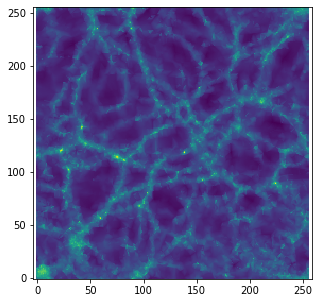

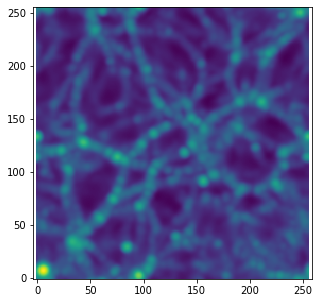

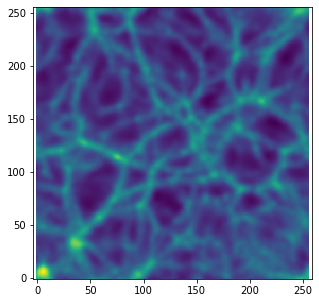

CPU times: user 9min 59s, sys: 2min 3s, total: 12min 3s
Wall time: 8min 37s


In [4]:
%%time
print("Load simulation")

L = 128
pro = 0.1

points = np.fromfile("N-body 3D/points.bin")
points = points.reshape((int(len(points) / 3), 3))

velocities = np.fromfile("N-body 3D/velocities.bin")
velocities = velocities.reshape((int(len(velocities) / 3), 3))

[points, velocities] = extend(points, velocities, L, pro)  

m = np.ones(len(points))

# DTFE estimation of the density and the velocity deformation modes
dtfe = DTFE(points, velocities, m)

n = int(2 * L)
X, Y, Z = np.meshgrid(np.arange(0, L, L / n),
                      np.arange(0, L, L / n),
                      np.arange(0, L, L / n))

dens  = dtfe.density(X.flat, Y.flat, Z.flat).reshape((n,n,n))
vel   = dtfe.v(X.flat, Y.flat, Z.flat).reshape((n,n,n,3))
div   = dtfe.theta(X.flat, Y.flat, Z.flat).reshape((n,n,n))
shear = dtfe.sigma(X.flat, Y.flat, Z.flat).reshape((n,n,n,3,3))
curl  = dtfe.omega(X.flat, Y.flat, Z.flat).reshape((n,n,n,3,3))

np.save("N-body 3D/dens", dens)
np.save("N-body 3D/vel", vel)
np.save("N-body 3D/div", div)
np.save("N-body 3D/shear", shear)
np.save("N-body 3D/curl", curl)

dens  = np.load("N-body 3D/dens.npy")
vel   = np.load("N-body 3D/vel.npy")
div   = np.load("N-body 3D/div.npy")
shear = np.load("N-body 3D/shear.npy")
curl  = np.load("N-body 3D/curl.npy")

densPlot(np.log(dens[0]), 5)
densPlot(np.log(GaussianSmooth(dens, 2)[0]), 5)
densPlot(np.log(LogGaussianSmooth(dens, 2)[0]), 5)

# Nexus_den

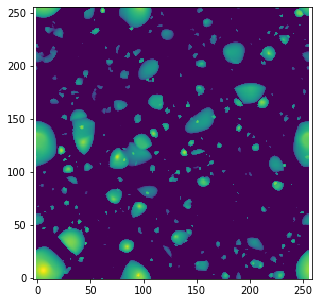

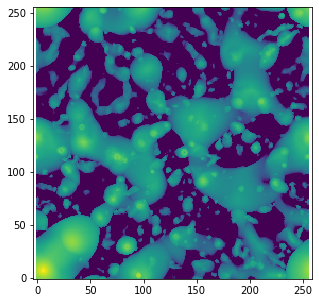

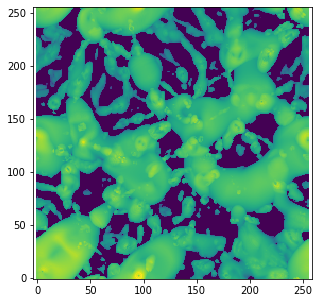

CPU times: user 1min 46s, sys: 44.5 s, total: 2min 30s
Wall time: 13min 16s


(1.9528127631164183, 4.6311343717880895, 0.982936676926761)

In [5]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(2,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_den(dens, sigma)).compute())
                       ,(2,3,4,1,0))

classes = np.amax(classes, axis=4)

np.save("N-body 3D/cluster_Nexus_den",  classes[...,0])
np.save("N-body 3D/filament_Nexus_den", classes[...,1])
np.save("N-body 3D/wall_Nexus_den",     classes[...,2])

densPlot(np.log(classes[...,0][0] + 0.00001), 5)
densPlot(np.log(classes[...,1][0] + 0.00001), 5)
densPlot(np.log(classes[...,2][0] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens), treshold(classes[...,2], dens))

# Nexus+

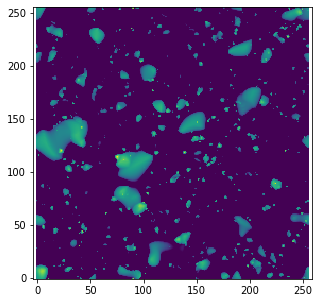

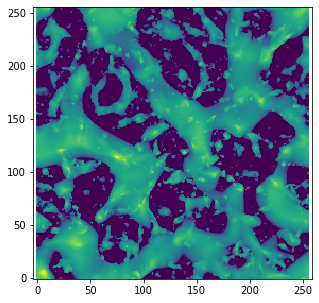

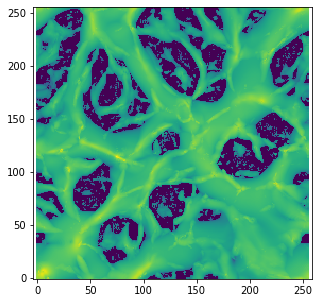

CPU times: user 1min 41s, sys: 44.4 s, total: 2min 25s
Wall time: 12min 27s


(0.16273908022029626, 2.682958888609365, 3.6093086453304077)

In [6]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(1,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: NexusPlus(dens, sigma)).compute())
                       ,(2,3,4,1,0))

classes = np.amax(classes, axis=4)

np.save("N-body 3D/cluster_Nexus+",  classes[...,0])
np.save("N-body 3D/filament_Nexus+", classes[...,1])
np.save("N-body 3D/wall_Nexus+",     classes[...,2])

densPlot(np.log(classes[...,0][0] + 0.00001), 5)
densPlot(np.log(classes[...,1][0] + 0.00001), 5)
densPlot(np.log(classes[...,2][0] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens), treshold(classes[...,2], dens))

# Nexus_tidal

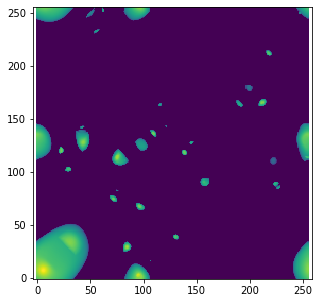

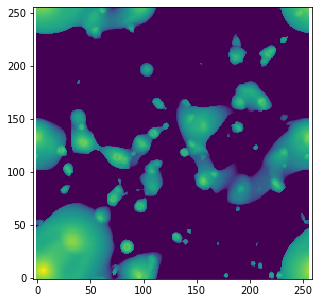

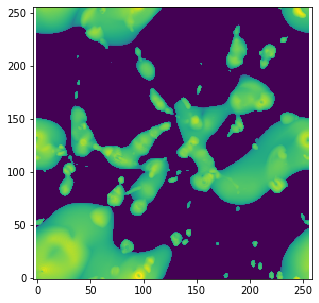

CPU times: user 1min 33s, sys: 35.3 s, total: 2min 9s
Wall time: 11min 36s


(0.5521365448076644, 3.578123389520608, 1.238726748599693)

In [7]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(2,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_tidal(dens, sigma)).compute())
                       ,(2,3,4,1,0))

classes = np.amax(classes, axis=4)

np.save("N-body 3D/cluster_Nexus_tidal",  classes[...,0])
np.save("N-body 3D/filament_Nexus_tidal", classes[...,1])
np.save("N-body 3D/wall_Nexus_tidal",     classes[...,2])

densPlot(np.log(classes[...,0][0] + 0.00001), 5)
densPlot(np.log(classes[...,1][0] + 0.00001), 5)
densPlot(np.log(classes[...,2][0] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens), treshold(classes[...,2], dens))

# Nexus_denlog

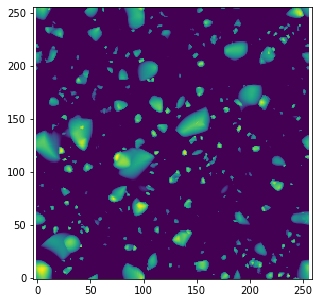

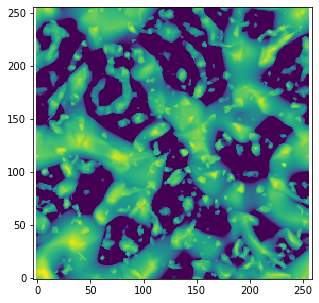

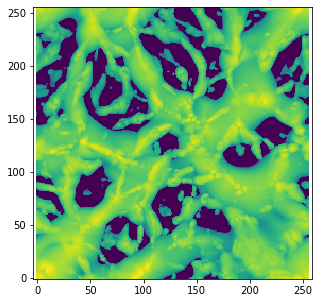

CPU times: user 1min 33s, sys: 33 s, total: 2min 6s
Wall time: 11min 2s


(0.01431269711533267, 0.09001268254176141, 0.0824966107907101)

In [8]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(2,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_den(np.log10(1 + dens), sigma)).compute())
                       ,(2,3,4,1,0))

classes = np.amax(classes, axis=4)

np.save("N-body 3D/cluster_Nexus_denlog",  classes[...,0])
np.save("N-body 3D/filament_Nexus_denlog", classes[...,1])
np.save("N-body 3D/wall_Nexus_denlog",     classes[...,2])

densPlot(np.log(classes[...,0][0] + 0.00001), 5)
densPlot(np.log(classes[...,1][0] + 0.00001), 5)
densPlot(np.log(classes[...,2][0] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens), treshold(classes[...,2], dens))

# Nexus_veldiv

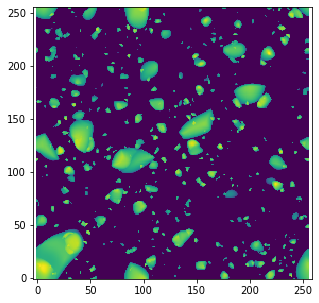

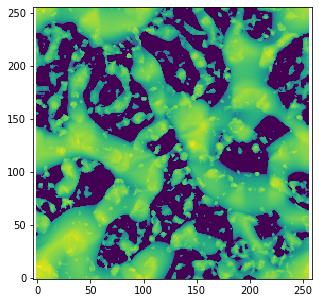

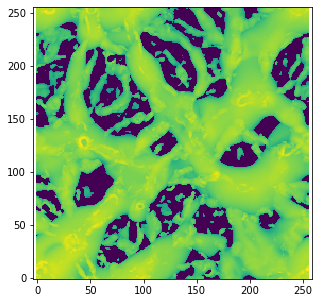

CPU times: user 1min 35s, sys: 43.1 s, total: 2min 18s
Wall time: 11min 5s


(1.0364740236189272, 10.477017079432953, 17.424711971393773)

In [9]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(2,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_veldiv(div, sigma)).compute())
                       ,(2,3,4,1,0))

classes = np.amax(classes, axis=4)

np.save("N-body 3D/cluster_Nexus_veldiv",  classes[...,0])
np.save("N-body 3D/filament_Nexus_veldiv", classes[...,1])
np.save("N-body 3D/wall_Nexus_veldiv",     classes[...,2])

densPlot(np.log(classes[...,0][0] + 0.00001), 5)
densPlot(np.log(classes[...,1][0] + 0.00001), 5)
densPlot(np.log(classes[...,2][0] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens), treshold(classes[...,2], dens))

# Nexus_velshear

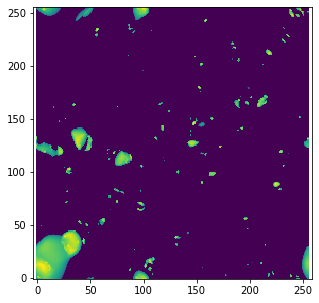

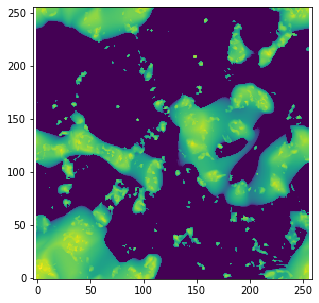

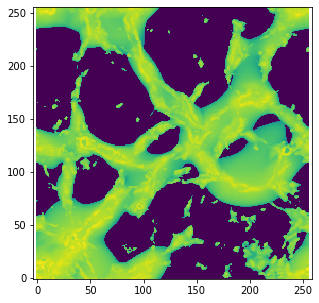

CPU times: user 1min 31s, sys: 44.1 s, total: 2min 15s
Wall time: 11min 22s


(0.44623501123745557, 14.276144039698366, 32.31521131384679)

In [10]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(1,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_velshear(div, sigma)).compute())
                       ,(2,3,4,1,0))

classes = np.amax(classes, axis=4)

np.save("N-body 3D/cluster_Nexus_velshear",  classes[...,0])
np.save("N-body 3D/filament_Nexus_velshear", classes[...,1])
np.save("N-body 3D/wall_Nexus_velshear",     classes[...,2])

densPlot(np.log(classes[...,0][0] + 0.00001), 5)
densPlot(np.log(classes[...,1][0] + 0.00001), 5)
densPlot(np.log(classes[...,2][0] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens), treshold(classes[...,2], dens))